<a href="https://colab.research.google.com/github/Abishethvarman/FakeNewsDetection/blob/sentiment-analysis/V1.9.Sentiment_Analysis_sentiment_LSTM_CNN_FakeNews_Full_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment Analysis on LSTM in CNN referring https://colab.research.google.com/drive/1Pa3M_NtsBiHCQ_1A2fudLfEQEyClwDv0

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Conv1D
from nltk.corpus import stopwords
from numpy import array
from numpy import asarray
from numpy import zeros
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [3]:
%cd /mydrive/dataset/

/content/gdrive/My Drive/dataset


In [4]:
df=pd.read_csv("fake-20000-SA-VADER-selected.csv")

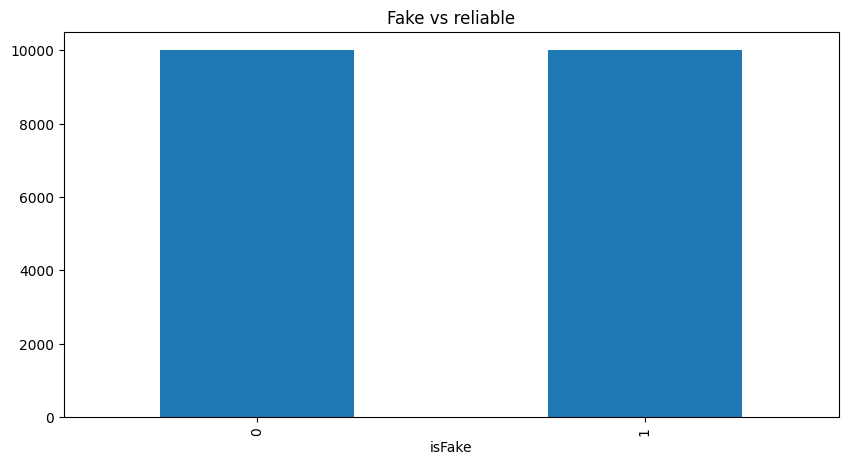

In [5]:
ax = df['isfake'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Fake vs reliable',
          figsize=(10, 5))
ax.set_xlabel('isFake')
plt.show()

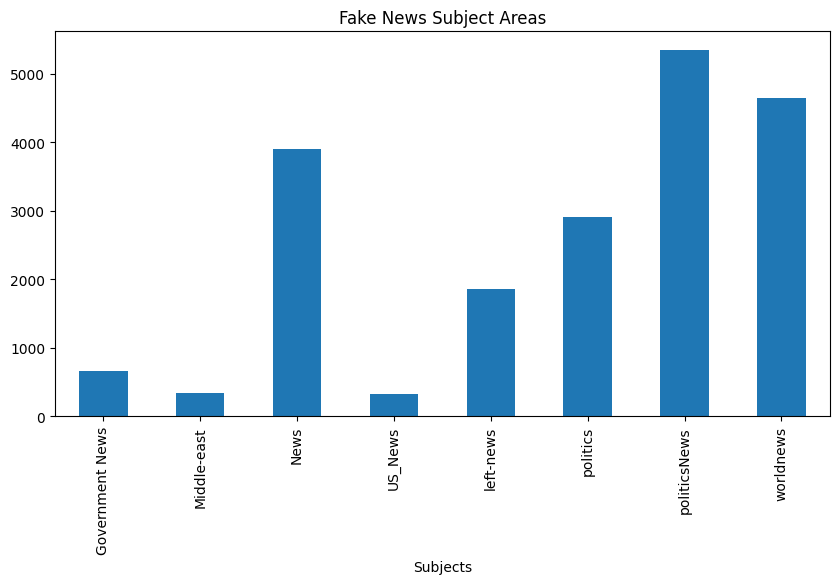

In [6]:
ax = df['subject'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Fake News Subject Areas',
          figsize=(10, 5))
ax.set_xlabel('Subjects')
plt.show()

In [7]:
df.head(3)

,Unnamed: 0.1,id,neg,neu,pos,compound,Unnamed: 0,title,text,subject,date,isfake,label,original,clean,sentiment
0,0,1,0.294,0.572,0.134,-0.9961,10650,Trump Supporters Terrorize An American Woman ...,Donald Trump s deplorable supporters strike ag...,News,"December 3, 2016",1,fake,Trump Supporters Terrorize An American Woman ...,Trump Supporters Terrorize American Woman Subw...,0
1,1,2,0.054,0.848,0.098,0.9797,2041,Trump adviser's Russia credentials come under ...,MOSCOW (Reuters) - When Donald Trump named a l...,politicsNews,"August 24, 2016",0,real,Trump adviser's Russia credentials come under ...,Trump adviser 's Russia credentials come scrut...,1
2,2,3,0.147,0.707,0.146,-0.8658,8668,Turkey feels betrayed over EU accession but st...,LONDON (Reuters) - Turkey feels betrayed by so...,worldnews,"September 14, 2017",0,real,Turkey feels betrayed over EU accession but st...,Turkey feels betrayed EU accession wants join ...,0


In [8]:
print(df['clean'][0])

Trump Supporters Terrorize American Woman Subway Wearing Hijab Donald Trump deplorable supporters strike again.18-year-old Yasmin Seweid born Brooklyn , New York . raised America entire life . grew surrounded American culture values religious freedom guaranteed Constitution.And able wear hijab practice Islam.But standing subway platform waiting go home , three male Trump supporters targeted began harassing . called terrorist , ripped straps bag , tried forcibly remove hijab saying Trump name.The abuse continued train Seweid forced exit early stop order away . Bystanders even watched incident unfold cowardly nothing stop it.She reported incident police , investigating crime.In order warn others dangers Trump supporters , Seweid chose write horrific experience Facebook . take train every single day going & coming class , yesterday , something happened never thought would happen , Seweid wrote . harassed subway last night dehumanizing speak without getting emotional . Three white racists 

In [9]:
df.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

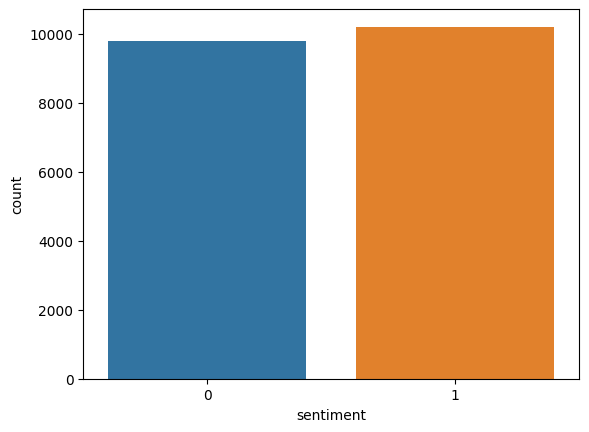

In [10]:
sns.countplot(x='sentiment', data=df)

In [11]:
def lower_text(sen):
    sentence = sen.lower()
    return sentence

In [12]:
X = []
sentences = list(df['clean'])
for sen in sentences:
    X.append(lower_text(sen))

In [13]:
y = df['sentiment']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [16]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

80589

In [17]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [18]:
embeddings_dictionary = dict()
glove_file = open('glove/a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [19]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [20]:
embedding_matrix.shape

(80589, 100)

In [21]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [22]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          8058900   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 8123157 (30.99 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 8058900 (30.74 MB)
_________________________________________________________________
None


In [23]:
# Model training
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
100/100 [==============================] - 13s 119ms/step - loss: 0.5585 - acc: 0.6991 - val_loss: 0.5228 - val_acc: 0.7347
Epoch 2/6
100/100 [==============================] - 11s 107ms/step - loss: 0.4570 - acc: 0.7870 - val_loss: 0.5034 - val_acc: 0.7500
Epoch 3/6
100/100 [==============================] - 12s 122ms/step - loss: 0.3979 - acc: 0.8310 - val_loss: 0.4945 - val_acc: 0.7544
Epoch 4/6
100/100 [==============================] - 11s 113ms/step - loss: 0.3507 - acc: 0.8640 - val_loss: 0.4858 - val_acc: 0.7578
Epoch 5/6
100/100 [==============================] - 9s 92ms/step - loss: 0.3074 - acc: 0.8940 - val_loss: 0.4834 - val_acc: 0.7609
Epoch 6/6
100/100 [==============================] - 11s 106ms/step - loss: 0.2613 - acc: 0.9219 - val_loss: 0.4815 - val_acc: 0.7666


In [24]:
# Predictions on the Test Set
score = cnn_model.evaluate(X_test, y_test, verbose=1)

125/125 [==============================] - 1s 9ms/step - loss: 0.4613 - acc: 0.7785


In [25]:
# Model Performance
print("Test Score:", score[0])
print(" Accuracy:", score[1])

Test Score: 0.46131739020347595
 Accuracy: 0.7785000205039978


In [27]:
# Model evaluation
y_pred_prob = cnn_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Other evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test,y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Model Performance
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:")
print(conf_matrix)


125/125 [==============================] - 2s 17ms/step
Accuracy: 0.7785
Precision: 0.7638259292837716
Recall: 0.8219512195121951
Confusion Matrix:
[[1429  521]
 [ 365 1685]]


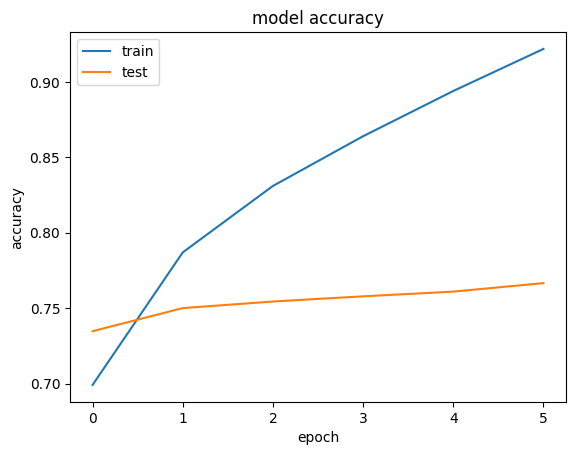

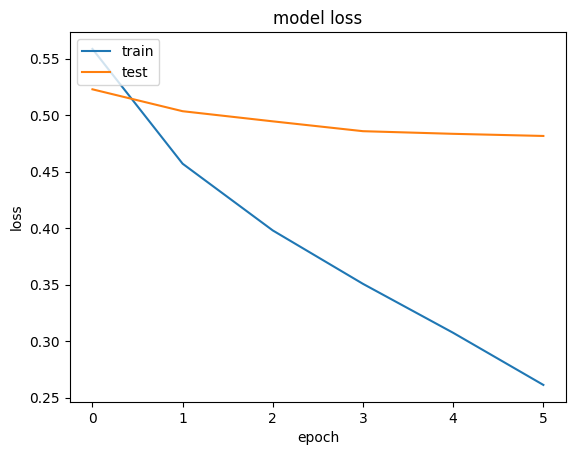

In [29]:
# Model Performance Charts

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

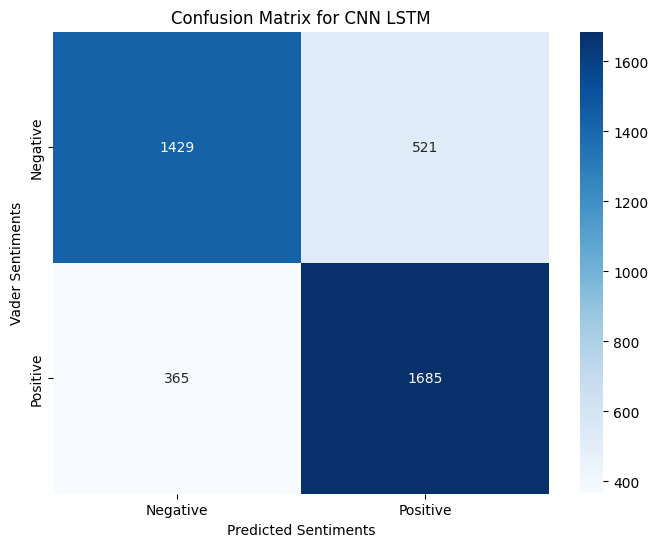

In [31]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Sentiments')
plt.ylabel('Vader Sentiments')
plt.title('Confusion Matrix for CNN LSTM')
plt.show()